In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import random

In [4]:
import keras

2022-12-03 00:10:55.436089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 00:10:55.938452: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-03 00:10:55.997760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 00:10:55.997793: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Importing the libraries to be used.

In [5]:
from keras.datasets import mnist

Using keras only to import the dataset.

In [6]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

print(type(train_x))
print(train_x.shape)
print(type(train_y))
print(train_y.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)
<class 'numpy.ndarray'>
(60000,)


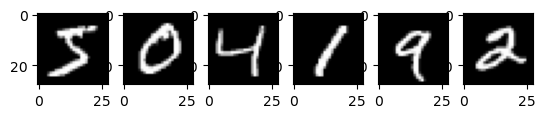

In [7]:
fig = plt.figure()


for i in range(6):
    fig.add_subplot(1,6,i+1)
    plt.imshow(train_x[i], vmin = 0, vmax = 255, cmap = 'gray')

plt.show()

Displaying first few digits of the training dataset.

In [8]:
train_x_upd = np.zeros(784*train_x.shape[0]).reshape(train_x.shape[0], 784)
for i in range(train_x.shape[0]):
  train_x_upd[i] = train_x[i].reshape(784)
  train_x_upd[i] = train_x_upd[i]/256

print(type(train_x_upd[1]))
print(train_x_upd[1].shape)

<class 'numpy.ndarray'>
(784,)


In [55]:
test_x_upd = np.zeros(784*test_x.shape[0]).reshape(test_x.shape[0], 784)
for i in range(test_x.shape[0]):
  test_x_upd[i] = test_x[i].reshape(784)
  test_x_upd[i] = test_x_upd[i]/256

print(type(test_x_upd[1]))
print(test_x_upd[1].shape)

<class 'numpy.ndarray'>
(784,)


In [56]:
print(test_y)

[7 2 1 ... 4 5 6]


Process the data to convert it from a 28x28 array to a 784x1 array. Further, the input is normalised by dividing the values by 256, so that the input layer activations lie between 0 and 1. 

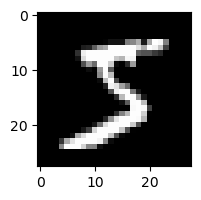

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [9]:
def output(x):
  out = np.zeros(10)
  out[x] = 1.0
  return out

fig = plt.figure(figsize=(2,2))

plt.imshow(train_x_upd[0].reshape(28,28), cmap='gray', vmin = 0, vmax = 1)
plt.show()

print(train_y[0])
w = output(train_y[0])
print(w)

In [10]:
print(train_y.shape)
output_arr = np.zeros(10*train_y.shape[0])
output_arr = output_arr.reshape(train_y.shape[0], 10)
print(output_arr.shape)

for i in range(train_y.shape[0]):
  output_arr[i] = output(train_y[i])

output_arr
train_y = output_arr.copy()

(60000,)
(60000, 10)


Convert the output labels into an array of size 10x1 which can be directly compared with the output layer activations.

In [13]:
def sigmoid_num(x):
  if(x > 20):
    return 1
  if(x < -20):
    return 0
  return (1/(1 + np.exp(-x)))

sigmoid = np.vectorize(sigmoid_num)
sigmoid(-5)

array(0.00669285)

In [15]:
def sigmoid_prime_num(x):
  return ((sigmoid_num(x))*(1 - sigmoid_num(x)))

sigmoid_prime = np.vectorize(sigmoid_prime_num)

The sigmoid function is the activation function. It has been vectorised to make it easy to apply on numpy arrays. Also to avoid np.exp overflow issues, sigmoid has been defines specifically for |x|>20.

In [57]:
class Network(object):

    #this class contains all the methods which are needed to train the network.
    #this class also has the weights, biases and neuron activations as attributes.

    def __init__(self, size_layers):
        self.inputlayer = np.zeros(size_layers[0])
        self.hiddenlayer = np.zeros(size_layers[1])
        self.outputlayer = np.zeros(size_layers[2])

        self.hid_z = np.zeros(size_layers[1])
        self.out_z = np.zeros(size_layers[2])

        self.out_error = np.zeros(size_layers[2])
        self.hid_error = np.zeros(size_layers[1])

        self.weights_inp_hid = np.random.normal(size = (size_layers[1],size_layers[0]))
        self.weights_hid_out = np.random.normal(size = (size_layers[2],size_layers[1]))

        self.bias_hid = np.random.normal(size = size_layers[1])
        self.bias_out = np.random.normal(size = size_layers[2])

    def feedfwd(self, a):
        #given an input image, this method calculates the neron activations at each layer of the network.
        self.inputlayer = a

        self.hid_z = np.matmul(self.weights_inp_hid, self.inputlayer) + self.bias_hid
        self.hiddenlayer = sigmoid(self.hid_z)

        self.out_z = np.matmul(self.weights_hid_out, self.hiddenlayer) + self.bias_out
        self.outputlayer = sigmoid(self.out_z)

    def backprop(self, expected_res):
        #this method calculates and returns the various terms of the gradient of the cost function, using the backpropagation algorithm
        self.out_error = np.multiply(self.outputlayer - expected_res, sigmoid_prime(self.out_z))
        self.hid_error = np.multiply(np.matmul(np.transpose(self.weights_hid_out), self.out_error), sigmoid_prime(self.hid_z))

        grad_bias_out = self.out_error
        grad_bias_hid = self.hid_error
        
        grad_weight_inp_hid = np.outer(self.hid_error, self.inputlayer)
        grad_weight_hid_out = np.outer(self.out_error, self.hiddenlayer)

        return grad_weight_inp_hid, grad_weight_hid_out, grad_bias_hid, grad_bias_out

    def gradient_desc(self, sample, learn_rate): 
        #sample is a list of tuples (x,y) where x is the input layer values, and y is the expected output.
        #this method calls backprop() to evaluate the gradient of the cost function. Then it averages the gradient over all inputs in sample and 
        #using this average gradient and the learn_rate, modifies the weights and biases (gradient descent)
        avg_grad_weight_inp_hid = np.zeros(shape = self.weights_inp_hid.shape)
        avg_grad_weight_hid_out = np.zeros(shape = self.weights_hid_out.shape)
        avg_grad_bias_hid = np.zeros(shape = self.bias_hid.shape)
        avg_grad_bias_out = np.zeros(shape = self.bias_out.shape)

        for a in sample:
            self.feedfwd(a[0])
            grad_weight_inp_hid, grad_weight_hid_out, grad_bias_hid, grad_bias_out = self.backprop(a[1])

            avg_grad_weight_inp_hid = (avg_grad_weight_inp_hid*i + grad_weight_inp_hid)/(i+1)
            avg_grad_weight_hid_out = (avg_grad_weight_hid_out*i + grad_weight_hid_out)/(i+1)
            avg_grad_bias_hid = (avg_grad_bias_hid*i + grad_bias_hid)/(i+1)
            avg_grad_bias_out = (avg_grad_bias_out*i + grad_bias_out)/(i+1)

        length = len(sample)

        self.weights_inp_hid -= (learn_rate/length) * avg_grad_weight_inp_hid
        self.weights_hid_out -= (learn_rate/length) * avg_grad_weight_hid_out
        self.bias_hid -= (learn_rate/length) * avg_grad_bias_hid
        self.bias_out -= (learn_rate/length) * avg_grad_bias_out

    def stochastic_batch(self, train_x_upd, train_y, batch_size, epochs, learn_rate, test_x_upd, test_y):
        #instead of taking the average over all of the inputs in the training data, we can divide the training data into random minibatches, 
        #and modify our weights and biases using the average gradient over the inputs of each minibatch.

        #we do this for the given number of epochs. Each epoch involves going over all the inputs of the training set.
        for epoch in range(epochs):
            train = [a for a in zip(train_x_upd, train_y)]
            random.shuffle(train)
            batches = [train[k: k+batch_size] for k in range(0, train_x_upd.shape[0], batch_size)]
            for batch in batches:
                self.gradient_desc(batch, learn_rate)

            evaluate = 0

            for i in range(test_x_upd.shape[0]):
                self.feedfwd(test_x_upd[i])
                if(test_y[i] == self.outputlayer.argmax()): evaluate+=1
            print("Epoch no. {0} done. Accuracy {1} pc".format(epoch, evaluate/test_x.shape[0]*100))

        

In [63]:
net = Network(size_layers=[784, 20, 10])

net.stochastic_batch(train_x_upd, train_y, 600, 30, 3000.0, test_x_upd, test_y)

Epoch no. 0 done. Accuracy 14.89 pc
Epoch no. 1 done. Accuracy 18.13 pc
Epoch no. 2 done. Accuracy 21.12 pc
Epoch no. 3 done. Accuracy 24.39 pc
Epoch no. 4 done. Accuracy 27.85 pc
Epoch no. 5 done. Accuracy 31.269999999999996 pc
Epoch no. 6 done. Accuracy 34.03 pc
Epoch no. 7 done. Accuracy 36.79 pc
Epoch no. 8 done. Accuracy 39.08 pc
Epoch no. 9 done. Accuracy 40.94 pc
Epoch no. 10 done. Accuracy 42.59 pc
Epoch no. 11 done. Accuracy 44.1 pc
Epoch no. 12 done. Accuracy 46.12 pc
Epoch no. 13 done. Accuracy 51.849999999999994 pc
Epoch no. 14 done. Accuracy 55.76 pc
Epoch no. 15 done. Accuracy 57.25 pc
Epoch no. 16 done. Accuracy 58.440000000000005 pc
Epoch no. 17 done. Accuracy 59.519999999999996 pc
Epoch no. 18 done. Accuracy 60.51 pc
Epoch no. 19 done. Accuracy 61.4 pc
Epoch no. 20 done. Accuracy 62.17 pc
Epoch no. 21 done. Accuracy 62.9 pc
Epoch no. 22 done. Accuracy 63.629999999999995 pc
Epoch no. 23 done. Accuracy 64.08 pc
Epoch no. 24 done. Accuracy 64.64 pc
Epoch no. 25 done. Accu

In [64]:
net.stochastic_batch(train_x_upd, train_y, 60, 30, 300.0, test_x_upd, test_y)

Epoch no. 0 done. Accuracy 67.4 pc
Epoch no. 1 done. Accuracy 67.69 pc
Epoch no. 2 done. Accuracy 67.93 pc
Epoch no. 3 done. Accuracy 68.31 pc
Epoch no. 4 done. Accuracy 68.63 pc
Epoch no. 5 done. Accuracy 69.03 pc
Epoch no. 6 done. Accuracy 69.3 pc
Epoch no. 7 done. Accuracy 69.6 pc
Epoch no. 8 done. Accuracy 69.93 pc
Epoch no. 9 done. Accuracy 70.33 pc
Epoch no. 10 done. Accuracy 70.82000000000001 pc
Epoch no. 11 done. Accuracy 71.08 pc
Epoch no. 12 done. Accuracy 71.28 pc
Epoch no. 13 done. Accuracy 71.54 pc
Epoch no. 14 done. Accuracy 71.78 pc
Epoch no. 15 done. Accuracy 72.15 pc
Epoch no. 16 done. Accuracy 72.43 pc
Epoch no. 17 done. Accuracy 72.97 pc
Epoch no. 18 done. Accuracy 73.45 pc
Epoch no. 19 done. Accuracy 73.92 pc
Epoch no. 20 done. Accuracy 74.63 pc
Epoch no. 21 done. Accuracy 75.19 pc
Epoch no. 22 done. Accuracy 75.67 pc
Epoch no. 23 done. Accuracy 76.16000000000001 pc
Epoch no. 24 done. Accuracy 76.57000000000001 pc
Epoch no. 25 done. Accuracy 77.03 pc
Epoch no. 26 do

In [65]:
net.stochastic_batch(train_x_upd, train_y, 10, 30, 30.0, test_x_upd, test_y)

Epoch no. 0 done. Accuracy 78.43 pc
Epoch no. 1 done. Accuracy 78.58000000000001 pc
Epoch no. 2 done. Accuracy 78.75999999999999 pc
Epoch no. 3 done. Accuracy 78.94 pc
Epoch no. 4 done. Accuracy 79.05 pc
Epoch no. 5 done. Accuracy 79.17 pc
Epoch no. 6 done. Accuracy 79.29 pc
Epoch no. 7 done. Accuracy 79.39 pc
Epoch no. 8 done. Accuracy 79.51 pc
Epoch no. 9 done. Accuracy 79.53 pc
Epoch no. 10 done. Accuracy 79.69000000000001 pc
Epoch no. 11 done. Accuracy 79.82000000000001 pc
Epoch no. 12 done. Accuracy 79.86 pc
Epoch no. 13 done. Accuracy 79.86999999999999 pc
Epoch no. 14 done. Accuracy 80.01 pc
Epoch no. 15 done. Accuracy 80.10000000000001 pc
Epoch no. 16 done. Accuracy 80.14 pc
Epoch no. 17 done. Accuracy 80.27 pc
Epoch no. 18 done. Accuracy 80.36999999999999 pc
Epoch no. 19 done. Accuracy 80.43 pc
Epoch no. 20 done. Accuracy 80.47999999999999 pc
Epoch no. 21 done. Accuracy 80.62 pc
Epoch no. 22 done. Accuracy 80.64 pc
Epoch no. 23 done. Accuracy 80.74 pc
Epoch no. 24 done. Accurac

In [66]:
net.stochastic_batch(train_x_upd, train_y, 60, 30, 300.0, test_x_upd, test_y)

Epoch no. 0 done. Accuracy 81.44 pc
Epoch no. 1 done. Accuracy 81.6 pc
Epoch no. 2 done. Accuracy 81.69999999999999 pc
Epoch no. 3 done. Accuracy 81.81 pc
Epoch no. 4 done. Accuracy 81.93 pc
Epoch no. 5 done. Accuracy 82.02000000000001 pc
Epoch no. 6 done. Accuracy 82.06 pc
Epoch no. 7 done. Accuracy 82.21000000000001 pc
Epoch no. 8 done. Accuracy 82.28999999999999 pc
Epoch no. 9 done. Accuracy 82.42 pc
Epoch no. 10 done. Accuracy 82.39999999999999 pc
Epoch no. 11 done. Accuracy 82.53 pc
Epoch no. 12 done. Accuracy 82.6 pc
Epoch no. 13 done. Accuracy 82.67999999999999 pc
Epoch no. 14 done. Accuracy 82.80999999999999 pc
Epoch no. 15 done. Accuracy 82.86 pc
Epoch no. 16 done. Accuracy 82.95 pc
Epoch no. 17 done. Accuracy 83.02000000000001 pc
Epoch no. 18 done. Accuracy 83.11 pc
Epoch no. 19 done. Accuracy 83.24000000000001 pc
Epoch no. 20 done. Accuracy 83.28 pc
Epoch no. 21 done. Accuracy 83.37 pc
Epoch no. 22 done. Accuracy 83.42 pc
Epoch no. 23 done. Accuracy 83.49 pc
Epoch no. 24 don

In [69]:
net.stochastic_batch(train_x_upd, train_y, 10, 100, 90.0, test_x_upd, test_y)

Epoch no. 0 done. Accuracy 84.07 pc
Epoch no. 1 done. Accuracy 84.09 pc
Epoch no. 2 done. Accuracy 84.27 pc
Epoch no. 3 done. Accuracy 84.3 pc
Epoch no. 4 done. Accuracy 84.43 pc
Epoch no. 5 done. Accuracy 84.52 pc
Epoch no. 6 done. Accuracy 84.64 pc
Epoch no. 7 done. Accuracy 84.72 pc
Epoch no. 8 done. Accuracy 84.94 pc
Epoch no. 9 done. Accuracy 84.98 pc
Epoch no. 10 done. Accuracy 85.1 pc
Epoch no. 11 done. Accuracy 85.16 pc
Epoch no. 12 done. Accuracy 85.2 pc
Epoch no. 13 done. Accuracy 85.34 pc
Epoch no. 14 done. Accuracy 85.39 pc
Epoch no. 15 done. Accuracy 85.55 pc
Epoch no. 16 done. Accuracy 85.56 pc
Epoch no. 17 done. Accuracy 85.66 pc
Epoch no. 18 done. Accuracy 85.75 pc
Epoch no. 19 done. Accuracy 85.74000000000001 pc
Epoch no. 20 done. Accuracy 85.83 pc
Epoch no. 21 done. Accuracy 85.91 pc
Epoch no. 22 done. Accuracy 85.92 pc
Epoch no. 23 done. Accuracy 85.97 pc
Epoch no. 24 done. Accuracy 85.97 pc
Epoch no. 25 done. Accuracy 86.05000000000001 pc
Epoch no. 26 done. Accuracy

In [72]:
np.savetxt("weights_inp_hid.csv", net.weights_inp_hid, delimiter= ',')
np.savetxt("weights_hid_out.csv", net.weights_hid_out, delimiter= ',')
np.savetxt("bias_hid.csv", net.bias_hid, delimiter= ',')
np.savetxt("bias_out.csv", net.bias_out, delimiter= ',')

In [74]:
evaluate = 0

for i in range(train_x_upd.shape[0]):
    net.feedfwd(train_x_upd[i])
    if(train_y[i].argmax() == net.outputlayer.argmax()): evaluate+=1
print("Accuracy {0} pc on training dataset".format(evaluate/train_x_upd.shape[0]*100))


Accuracy 88.09 pc on training dataset
